# Terminal currents

The stream function $g(\vec{r})=g(x, y)$ and supercurrent density $\vec{J}(x, y)$ are related according to $\vec{J}=\vec{\nabla}\times(g\hat{z})=(\partial g/\partial y, -\partial g/\partial x)$. For some assumed supercurrent distribution $\vec{J}$, the associated stream function $g$ is given by $g(\vec{r})=g(\vec{r}_0) + \int_{\vec{r}_0}^\vec{r}(\hat{z}\times\vec{J})\cdot\mathrm{d}\vec{\ell}$, where $\hat{z}\times\vec{J}=(-J_y, J_x)$.

We make the following assumptions regarding terminal currents:

1. The current density $|\vec{J}|$ is uniformly distributed along the terminal.
2. Current direction $\vec{J}/|\vec{J}|$ is everywhere perpendicular to the terminal direction.

In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 96

import superscreen as sc

In [2]:
width = 1
height = width * 2
slot_height = height / 5
slot_width = width / 4
dx, dy = center = (0, 0)
length_units = "um"

film = sc.Polygon(
    "film", layer="base", points=sc.geometry.box(width, height)
).difference(
    sc.geometry.box(slot_width, slot_height, center=(-(width - slot_width) / 2, 0))
).difference(
    sc.geometry.box(slot_width, slot_height, center=(+(width - slot_width) / 2, 0))
).resample(251)

source_terminal = sc.Polygon(
    "source", points=sc.geometry.box(width, height / 100, center=(0, height / 2))
)
drain_terminal = sc.Polygon(
    "drain", points=sc.geometry.box(width, height / 100, center=(0, -height / 2))
)

device = sc.TransportDevice(
    "constriction",
    layer=sc.Layer("base", Lambda=0.1),
    film=film,
    source_terminals=[source_terminal],
    drain_terminal=drain_terminal,
    length_units=length_units,
).translate(dx=dx, dy=dy)

In [3]:
device.make_mesh(min_points=2000, optimesh_steps=20)

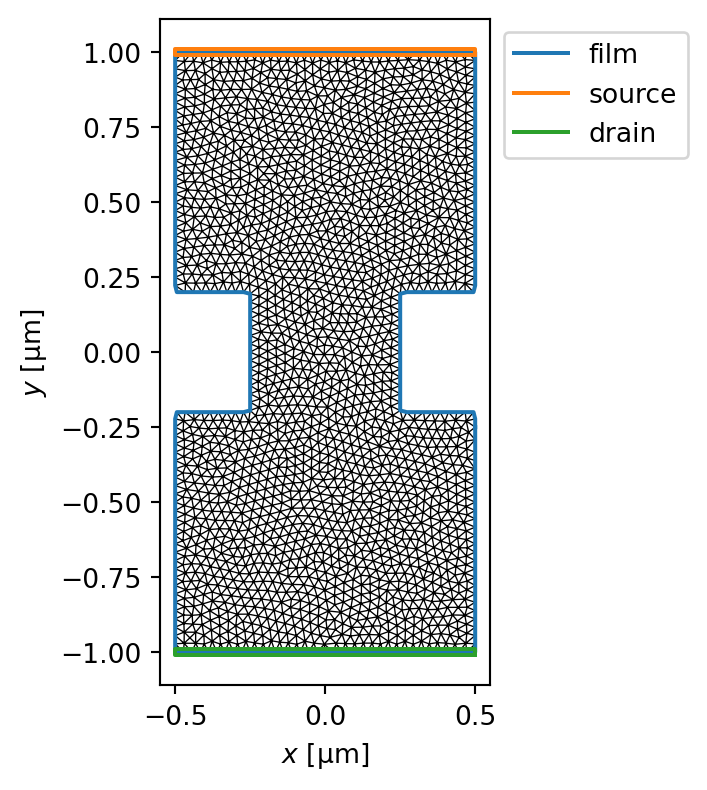

In [4]:
_ = device.plot(mesh=True, mesh_kwargs=dict(color="k", lw=0.5))

In [5]:
terminal_currents = {"source": "100 uA"}

solution = sc.solve(
    device,
    applied_field=sc.sources.ConstantField(100),
    terminal_currents=terminal_currents,
    field_units="uT",
)[-1]

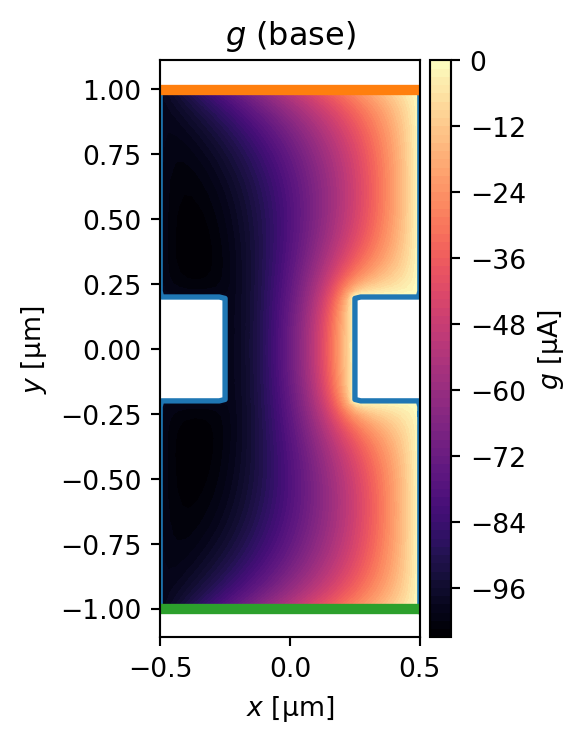

In [6]:
fig, axes = solution.plot_streams()
for polygon in device.polygons.values():
    polygon.plot(ax=axes[0], lw=2)

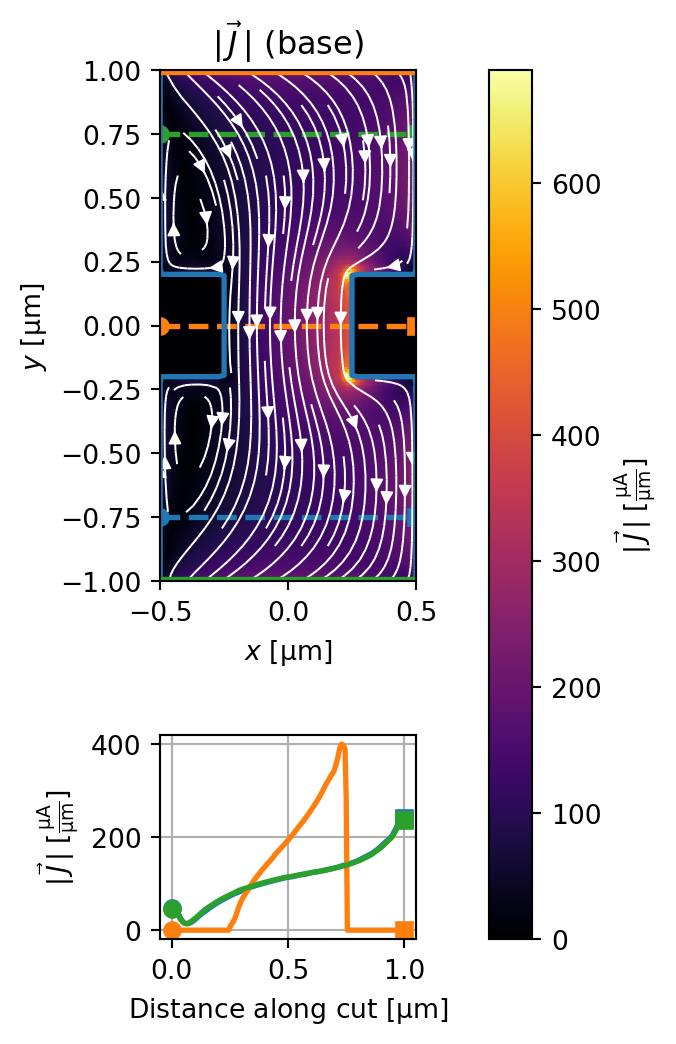

In [7]:
xs = np.linspace(-width / 2, +width / 2, 201)
ys = np.ones_like(xs)
cross_sections = [np.stack([xs, y0 * ys], axis=1) for y0 in (-0.75, 0, 0.75)]


fig, axes = solution.plot_currents(
    streamplot=True,
    cross_section_coords=cross_sections,
    figsize=(3, 6),
    grid_method="cubic",
)
for polygon in device.polygons.values():
    polygon.plot(ax=axes[0], lw=2)